<a href="https://colab.research.google.com/github/mingshey/maximacas/blob/main/Refraction_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 물 속 공간의 굴절상

* 목표: 물 속 공간을 격자 모양으로 구획하여 물 밖에서 본 상의 모습을 구한다.

* 방법:
1. POV(관측점, 수면 위)와 물 속 물체의 위치(OBJ)가 주어졌을 때 최소 시간 원리를 이용하여 입사점을 구한다.
2. 물체에서 입사점 근방 두 점으로 나오는 광선 각각의 굴절각을 이용하여 물 밖으로 굴절하여 나오는 광선 각각의 1차 방정식을 구한다.
3. 두 방정식을 연립하여 풀어 상의 위치를 구한다.
4. 1~3 과정을 함수로 만든다.
5. 4에서 만든 함수를 이용하여 물속 격자의 상을 구한다.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import sympy as sym
import scipy as sci

In [ ]:
# 각각 공기와 물의 굴절률
n1, n2 = 1, 1.33

In [ ]:
N1, N2, A, B, C, D, x = sym.symbols('n_1, n_2, A B C D x')

In [ ]:
path1 = sym.sqrt((x-A)**2 + B**2)
path2 = sym.sqrt((C-x)**2 + D**2)
ptime = N1*path1 + N2*path2
ptimef = sym.lambdify((x, N1, N2, A, B, C, D), ptime)

In [ ]:
Dptime = sym.diff(ptime, x)
Dptimef = sym.lambdify((x, N1, N2, A, B, C, D), Dptime)

In [ ]:
s1 = [0, 1]
s2 = [1, -1]

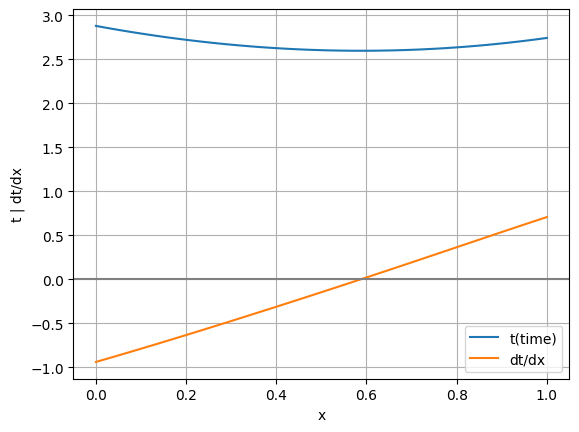

In [ ]:
xs = np.linspace(0, 1, 100)
plt.plot(xs, ptimef(xs, n1, n2, s1[0], s1[1], s2[0], s2[1]), label='t(time)')
plt.plot(xs, Dptimef(xs, n1, n2, s1[0], s1[1], s2[0], s2[1]), label='dt/dx')
plt.grid()
plt.axhline(0,c='gray')
plt.xlabel('x')
plt.ylabel('t | dt/dx')
plt.legend()

0.5878671239391607


Text(0.6378671239391608, 0, 'x0: point of incidence')

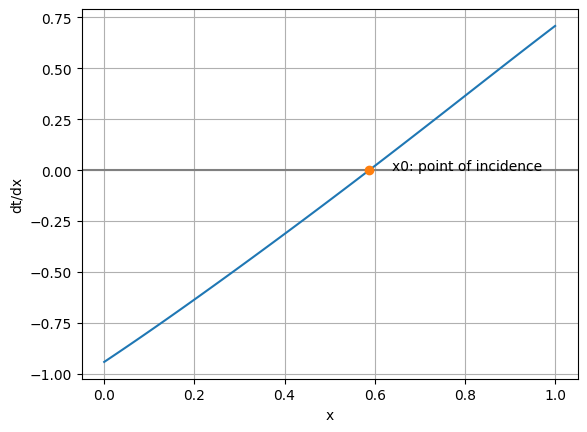

In [ ]:
dpt = lambda x: Dptimef(x, n1, n2, s1[0], s1[1], s2[0], s2[1])

sol = sci.optimize.root(dpt, s2[0])
x0 = sol.x[0]
print(x0)

x = np.linspace(0, 1, 100)
plt.plot(x, dpt(x))
plt.grid()
plt.xlabel('x')
plt.ylabel('dt/dx')
plt.axhline(0,c='gray')
plt.plot(x0, 0, 'o')
plt.text(x0+0.05, 0, 'x0: point of incidence')

In [ ]:
# 굴절 법칙을 만족하는지 확인
from re import X
sin1 = (s1[0] - x0) / np.sqrt((x0 - s1[0])**2 + s1[1]**2)
sin2 = (x0 - s2[0]) / np.sqrt((x0 - s2[0])**2 + s2[1]**2)
print(f"sin1/sin2={sin1/sin2}")
print(f"n2/n1={n2/n1}")

sin1/sin2=1.3300000000000003
n2/n1=1.33


In [ ]:
# 광선의 경로
pts = np.array([s2, [x0, 0], s1])

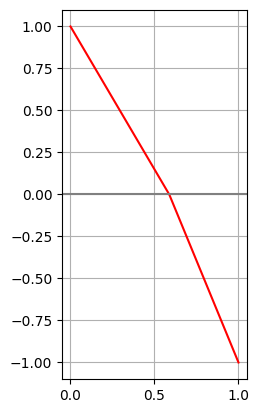

In [ ]:
# 광선의 경로를 그려 본다
plt.axes().set_aspect('equal')
plt.plot(pts.T[0], pts.T[1], 'r')
plt.axhline(0, c='gray')
plt.grid()

In [ ]:
# 입사점 근방으로 나오는 다른 광선의 경로
eps = 3e-2
xm, xp = x0 - eps, x0 + eps
x2, y2 = s2[0], s2[1]
dxm = xm - x2
dxp = xp - x2
d = y2

sin2m = dxm / np.sqrt(dxm**2 + d**2)
sin2p = dxp / np.sqrt(dxp**2 + d**2)

# 스넬 법칙
sin1m = n2 / n1 * sin2m
sin1p = n2 / n1 * sin2p

# 전반사되는 경우는 제대로 예외 처리 해야 하나
# 물체에서 관측점으로 광선이 도달하는 경우를 중심으로
# 미세한 변화만을 준 것이므로 전반사는 없는 것으로 간주하여
# 여기서는 대충 얼버무리기로 한다.
if sin1m > 1:
  sin1m = 1
if sin1p > 1:
  sin1p = 1

# 굴절광선(물 밖) 방향으로 길이 1인 각 선분의 끝 점(s1m, s1p)을 구한다.
x1m = sin1m
x1p = sin1p

y1m = np.sqrt(1-x1m**2)
y1p = np.sqrt(1-x1p**2)

s1m = np.array([xm+x1m, y1m])
s1p = np.array([xp+x1p, y1p])

In [ ]:
# 입사점 근방으로 나오는 광선의 연립 방정식
pcm = np.polyfit(np.array([xm, xm+x1m]), np.array([0, y1m]), 1)
pcp = np.polyfit(np.array([xp, xp+x1p]), np.array([0, y1p]), 1)
eqn2 = lambda x: np.poly1d(pcm)(x) - np.poly1d(pcp)(x)

In [ ]:
# 연립 방정식의 해
sol2 = sci.optimize.root(eqn2,x2)
ix = sol2.x[0]
iy = np.poly1d(pcm)(ix)
print(ix, iy)

0.9464178427677785 -0.6090803888696094


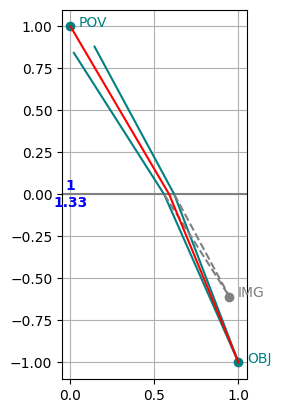

In [ ]:
# POV 와 물체를 잇는 광선 및 입사점 근처로 나오는 광선,
# 두 광선의 굴절 후 경로의 연장선 및 교점을 그려 본다
plt.axes().set_aspect('equal')

plt.axhline(0, c='gray')
plt.text(s1[0], 0.01, str(n1), color='b', va='bottom', ha='center', weight='bold')
plt.text(s1[0], -0.01, str(n2), color='b', va='top', ha='center', weight='bold')

plt.grid()
pathm = np.array([s2, [xm, 0], s1m])
pathp = np.array([s2, [xp, 0], s1p])

plt.plot(pathm.T[0], pathm.T[1], 'teal')
plt.plot(pathp.T[0], pathp.T[1], 'teal')
plt.plot(s1[0], s1[1], 'o', color='teal')
plt.plot(s2[0], s2[1], 'o', color='teal')
plt.text(s1[0]+0.05, s1[1], 'POV', color='teal')
plt.text(s2[0]+0.05, s2[1], 'OBJ', color='teal')

plt.plot([xm, ix], [0, iy],color='gray', linestyle='--')
plt.plot([xp, ix], [0, iy],color='gray', linestyle='--')
plt.plot(ix, iy, 'o', color='gray')
plt.text(ix+0.05, iy, 'IMG', color='gray')

plt.plot(pts.T[0], pts.T[1], 'r')

In [ ]:
# 상의 위치를 구하는 함수
def refimg(pov, obj, nrel):
  '''
  pov: [xp, yp]; 관측점
  obj: [xo, yo]; 물체의 위치
  nrel: 물체와 물의 굴절률 비율, nrel=n2/n1
  '''
  xp, yp = pov[0], pov[1]
  xo, yo = obj[0], obj[1]
  x0 = sci.optimize.root(lambda x: Dptimef(x, 1, nrel, xp, yp, xo, yo), xo).x[0]

  eps = 1e-6
  xm, xp = x0 - eps, x0 + eps
  dxm = xm - xo
  dxp = xp - xo
  d = yo

  sin2m = dxm / np.sqrt(dxm**2 + d**2)
  sin2p = dxp / np.sqrt(dxp**2 + d**2)

  sin1m = n2 / n1 * sin2m
  sin1p = n2 / n1 * sin2p

  if sin1m > 1:
    sin1m = 1
  if sin1p > 1:
    sin1p = 1

  x1m = sin1m
  x1p = sin1p

  y1m = np.sqrt(1-x1m**2)
  y1p = np.sqrt(1-x1p**2)

  pcm = np.polyfit(np.array([xm, xm + x1m]), np.array([0, y1m]), 1)
  pcp = np.polyfit(np.array([xp, xp + x1p]), np.array([0, y1p]), 1)

  eqn2 = lambda x: np.poly1d(pcm)(x) - np.poly1d(pcp)(x)

  sol = sci.optimize.root(eqn2,s2[0])
  ix = sol.x[0]
  iy = np.poly1d(pcm)(ix)

  return np.array([ix, iy])

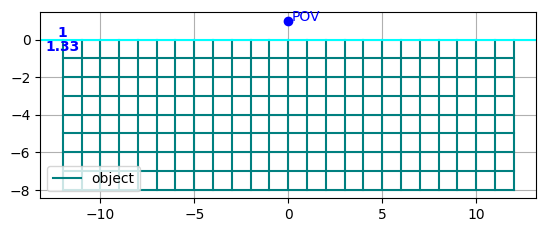

In [ ]:
pov = [0, 1]
xspan = 12
depth = 8

# 수면 아래 격자 모양의 물체
oxs = np.linspace(-xspan, xspan, 200)
oys = np.ones_like(oxs)

oys2 = np.linspace(-depth, 0, 100)
ox2 = np.ones_like(oys2)

plt.axes().set_aspect('equal')

for j in range(1, depth+1):
  if j==1:
    plt1 = plt.plot(oxs, oys * -j, 'teal', label='object')
  else:
    plt1 = plt.plot(oxs, oys * -j, 'teal')

for k in range(-xspan, xspan+1):
  plt.plot(ox2*k, oys2, 'teal')

plt.plot(pov[0], pov[1], 'o', color='b')
plt.text(pov[0]+0.2, pov[1], 'POV', color='b')

plt.axhline(0, c='cyan')
plt.grid()

plt.text(-xspan, 0, str(n1), color='b', va='bottom', ha='center', weight='bold')
plt.text(-xspan, 0, str(n2), color='b', va='top', ha='center', weight='bold')

plt.legend(loc='lower left')

<ipython-input-20-fe156123f99e>:32: RuntimeWarning: invalid value encountered in sqrt
  y1m = np.sqrt(1-x1m**2)


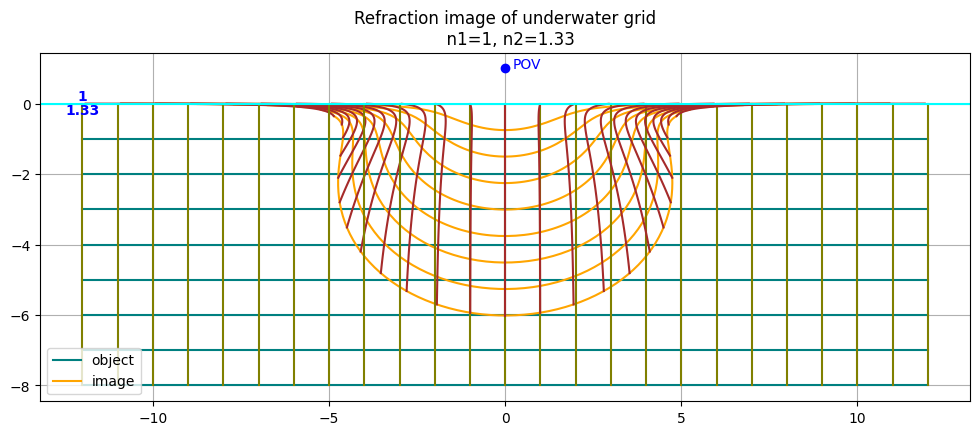

In [30]:
# 격자 모양 물체의 상
imgs1 = np.array([[refimg(pov, [ox, oy], 1.33) for ox, oy in zip(oxs, oys * -j)] for j in range(1, depth+1)])

imgs2 = np.array([[refimg(pov, [ox, oy], 1.33) for ox, oy in zip(ox2*k, oys2)] for k in range(-xspan, xspan+1)])

plt.figure(figsize=(12, 5))
plt.axes().set_aspect('equal')

for j in range(1, depth+1):
  if j==1:
    plt1 = plt.plot(oxs, oys * -j, 'teal', label='object')
    plt2 = plt.plot(imgs1[j-1].T[0], imgs1[j-1].T[1], 'orange', label='image')
  else:
    plt1 = plt.plot(oxs, oys * -j, 'teal')
    plt2 = plt.plot(imgs1[j-1].T[0], imgs1[j-1].T[1], 'orange')

for k in range(-xspan, xspan+1):
  plt.plot(ox2*k, oys2, 'olive')
  plt.plot(imgs2[k+xspan].T[0], imgs2[k+xspan].T[1], 'brown')

plt.plot(pov[0], pov[1], 'o', color='b')
plt.text(pov[0]+0.2, pov[1], 'POV', color='b')

plt.axhline(0, c='cyan')
plt.grid()

plt.title('Refraction image of underwater grid\n  n1=1, n2=1.33')
plt.text(-xspan, 0, str(n1), color='b', va='bottom', ha='center', weight='bold')
plt.text(-xspan, 0, str(n2), color='b', va='top', ha='center', weight='bold')

plt.legend(loc='lower left')

plt.savefig('refimg.svg')